# Setup - defining parameters that probably don't change

In [15]:

#user defined parameters

#thresholds for spot detection (*std)
sigmaFind=50   #threshold for finding spots
sigmaCent=15   #threshold for calculating moments

#other spot detection parameters - probably won't need to change
boxFind=10   #box size for finding spots
boxCent=6   #box size for centroiding
nmin=10     #minimum acceptable # of pixels in spot
nmax=90     #maximum acceptable # of pixels in spot
maxIt=20    #maximum # interations for centroiding

#paramters for finding threshiood

sigmaThresh=4
threshFact=2

#set to non zero to override automatic fwhm determination
fwhmx=0
fwhmy=0

#inter = 1 for notebook, 0 for scripts (displaying plots)
inter=1

#cenFlag='local' to run from local disk, 'db' to read from database
cenFlag='local'
#cenFlag='db'

#dataSource = 'pinhole'
dataType='pinhole'

#configuration for rotator center

config="oct18"
#config="aug19"
#config=None



#database info - update as needed
user='pfs'
passwd='fps'
host='133.40.164.208'
dbname='pfspass'
conn=None


# Setup - importing

In [21]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip
import sys
from importlib import reload  #for debugging purposes

#kludge - need to change???
sys.path.append("/Users/karr/Science/PFS/NewCode/Code/pfs_utils/python/pfs/utils/coordinates/")
import CoordTransp
import DistortionCoefficients

#the try/except is for using in the MHS environment, or standalone. 


try:
    import mcsActor.Visualization.mcsRoutines as mcs
except:
    import mcsRoutines as mcs

try:
    import mcsActor.Visualization.fpsRoutines as fps
except:
    import fpsRoutines as fps

try:
    import mcsActor.Visualization.visRoutines as vis
except:
    import visRoutines as vis

try:
    import mcsActor.Visualization.vis_plot as visplot
except:
    import vis_plot as visplot



# setup - connect to database, load instrument parameters

In [11]:

reload(vis)
#connect to database if in DB mode
if(cenFlag=='db'):
    conn=vis.dbConnect(user=user,dbname=dbname,passwd=pfspass,host=host)
    
#read instrument parameters if available
if(config != "calib"):
    rotCent,offset=vis.loadInstParams(config)


# setup - parameters that change for each run

In [12]:

#set frame ID minimum and maximum values (inclusive)

frameId1=2498
frameId2=2508

#a list of any frames to skip (bad data, etc). Can be empty.
frameSkip=[]   

za=0

#source directory data files in local mode
sourceDir="/Volumes/Vaal/Commissioning Run/2018-10-24/"

#subtitle for plots - currently set to first frame ID plus tag
stitle=" ["+str(frameId1).zfill(6)+"]"

fPref="PFSC"
#get various file name inforamtion
files,prefix,centroidFile,frameIDs=vis.getFileNames(frameId1,frameId2,frameSkip,sourceDir,fPref,dataType)

nfiles=len(files)
print("Read "+str(len(files))+" files names. First = "+str(frameId1)+" Last="+str(frameId2))
print("prefix="+prefix+" centroidFile="+centroidFile)


Read 11 files names. First = 2498 Last=2508
prefix=see_02498_02508 centroidFile=see_02498_02508_centroids.dat


# calculate threshold values and region (once per config)

Thresholds= 1843.855619174775 1142.6118278292856
Boundaries of region (x1,x2,y1,y2):  1126 5060 3684 7601


<IPython.core.display.Javascript object>


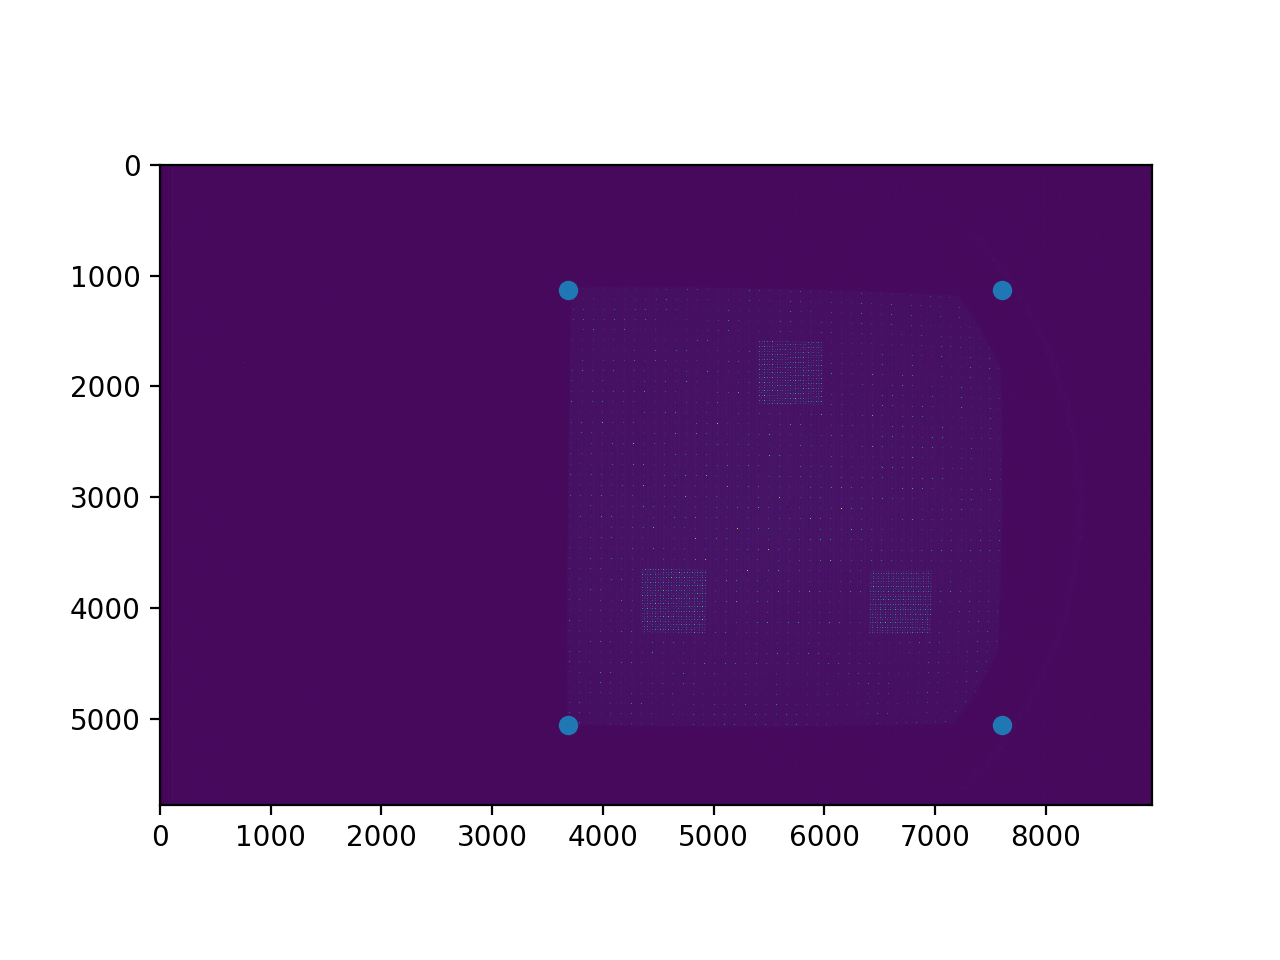

In [23]:
#not needed if pulling from DB
reload(vis)
reload(mcs)
reload(visplot)
config='calib'

if((cenFlag=='local')):
    
    #if config is not known, find the region (must be rotate by multiple of 90 degrees)
    if(config=='calib'):
        image=vis.getImage(files[0])
        findThresh,centThresh,xrange,yrange=mcs.getThresh(image,'calib',sigmaThresh,threshFact,sigmaFind,sigmaCent)

    #if config is known, calculate the region for the threshold from the coord transforms
    else:
        findThresh,centThresh,xrange,yrange=mcs.getThresh(image,'fieldID',sigmaThresh,threshFact,sigmaFind,sigmaCent)
        

    print("Thresholds=",findThresh,centThresh)
    print("Boundaries of region (x1,x2,y1,y2): ",xrange[0],xrange[1],yrange[0],yrange[1])

    visplot.checkThreshold(image,xrange,yrange)


# Do the centroiding for a set of data, either locally or retrieve from DB


In [24]:
reload(vis)

#set redo=1 to recalculate values, redo=0 to read from files    
redo=1

#local case - either read files and calculate, or load data from a file. 
if(cenFlag=="local"):

    boxfind=10
    if(redo==1):
        print("Centroiding with Parameters: ",thresh1,thresh2,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)
        xfirst,xlast=vis.getAllCentroids(files,centroidFile,thresh1,thresh2,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)
        centroids=np.loadtxt(centroidFile)
    else:
        print("Loading Centroids from File.")
        centroids=np.loadtxt(centroidFile)
#db case - read from database
elif(cenFlag=='db'):
    printf("Loading Centroids from DB.")
    centroids=vis.getCentroidsDB(conn,frameIDs)        
        
#extract the first set of centroids for summary plot, and for referencing points later
ind=np.where(centroids[:,0]==0)
xfirst=centroids[ind,1].ravel()
yfirst=centroids[ind,2].ravel()
         
#vis.checkCentroids(xfirst,yfirst,1,prefix,inter)


Centroiding with Parameters:  1843.855619174775 1142.6118278292856 0 0 10 6 10 90 20
11 Frames. Centroiding 1: 3539, 2: 3540, 3: 3541, 4: 3542, 5: 3539, 6: 3542, 7: 3541, 8: 3539, 9: 3536, 10: 3540, 11: 3540, 


In [26]:
reload(vis)

#match all the frames to the first frame
tol=20
xArray,yArray,fxArray,fyArray,backArray,peakArray,qualArray=vis.matchAllPoints(centroids,xfirst,yfirst,tol)
    
#get transformations by frame
xdAll,ydAll,sxAll,syAll,rotAll,fxFrameAv,fyFrameAv,peakFrameAv,transAll = vis.getTransByFrame(xArray,yArray,fxArray,fyArray,peakArray,xfirst,yfirst)

#sAll=(sxAll+syAll)/2
xAv,yAv,fxAv,fyAv,peakAv,backAv,rmsVal,nMatch,xArray1,yArray1,dd,rmsX,rmsY,xd,yd = vis.getRMSStats(xArray,yArray,fxArray,fyArray,peakArray,backArray,xdAll,ydAll,sxAll,syAll,rotAll,xfirst,yfirst)



10 frames. Matching 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
Translating 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 


/Users/karr/ics_mcsActor/python/mcsActor/Visualization/visRoutines.py:575: RuntimeWarning: invalid value encountered in sqrt
  dd[i,:]=np.sqrt((xArray1[i,:]-xm[i])**2+(yArray1[i,:]-ym[i])**2)
/Users/karr/ics_mcsActor/python/mcsActor/Visualization/visRoutines.py:576: RuntimeWarning: invalid value encountered in sqrt
  xd[i,:]=np.sqrt((xArray1[i,:]-xm[i])**2)
/Users/karr/ics_mcsActor/python/mcsActor/Visualization/visRoutines.py:577: RuntimeWarning: invalid value encountered in sqrt
  yd[i,:]=np.sqrt((yArray1[i,:]-ym[i])**2)



# Image Quality Plots

Now we get into the analysis part. 

Plots of FWHM values, peak values, and a rough calculation of total flux.  Set plotrange to the range you want for the colour bar (2 element numpy array); the default is min and max. 


<IPython.core.display.Javascript object>


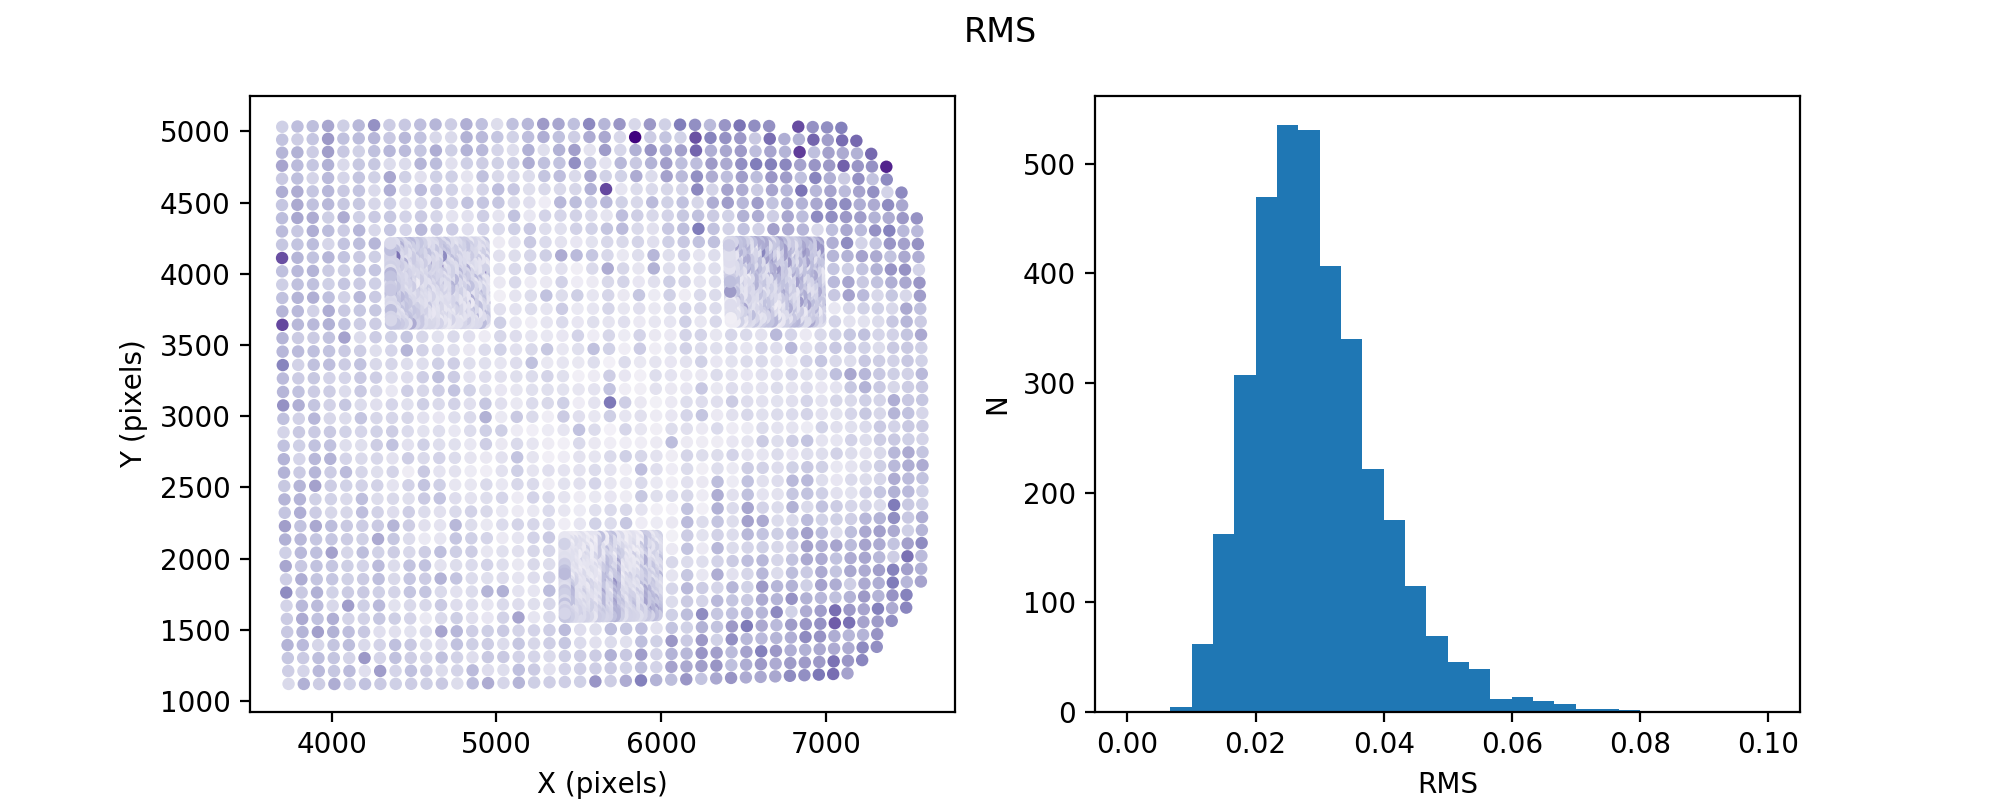

<IPython.core.display.Javascript object>


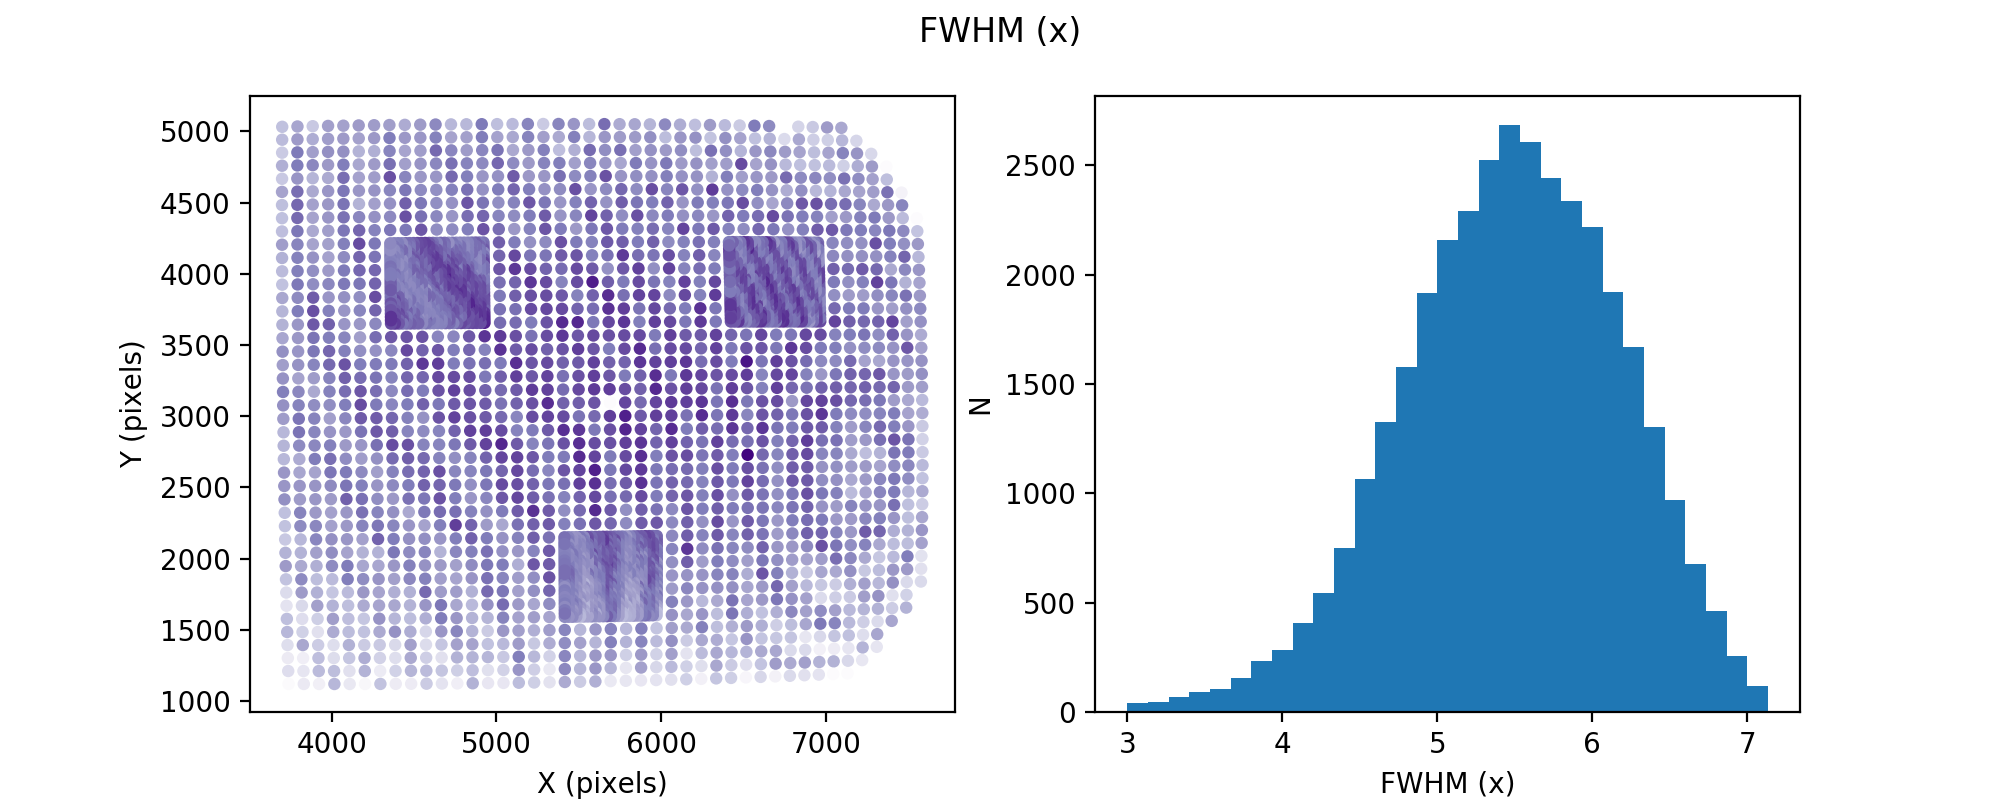

<IPython.core.display.Javascript object>


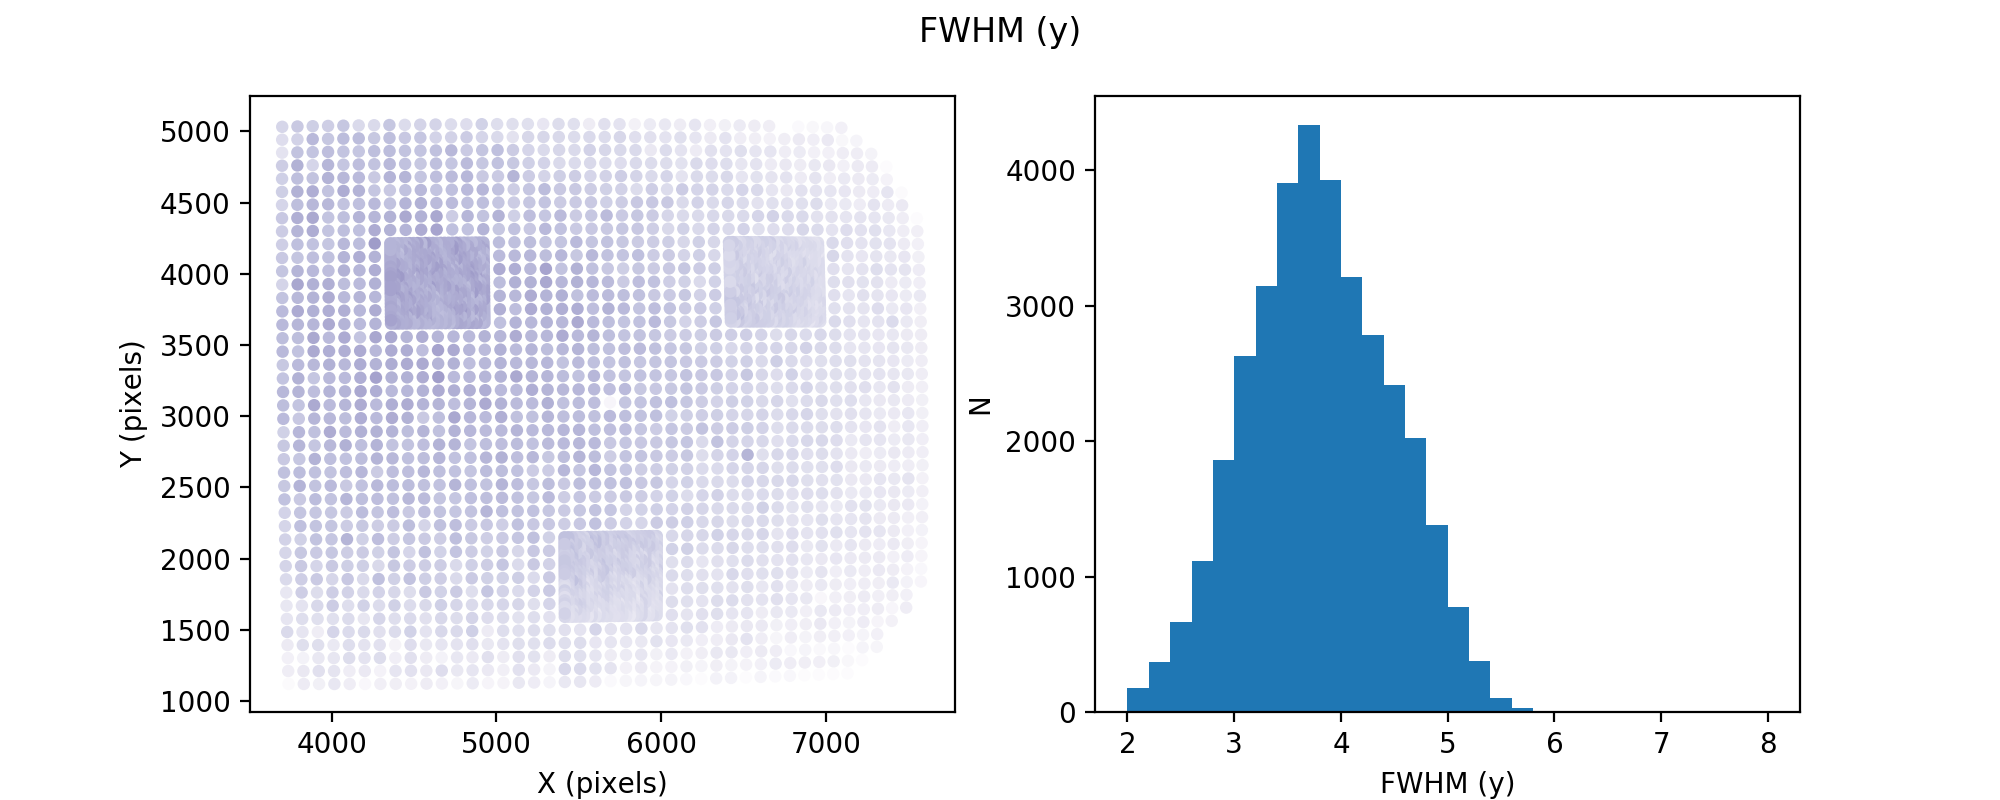

<IPython.core.display.Javascript object>


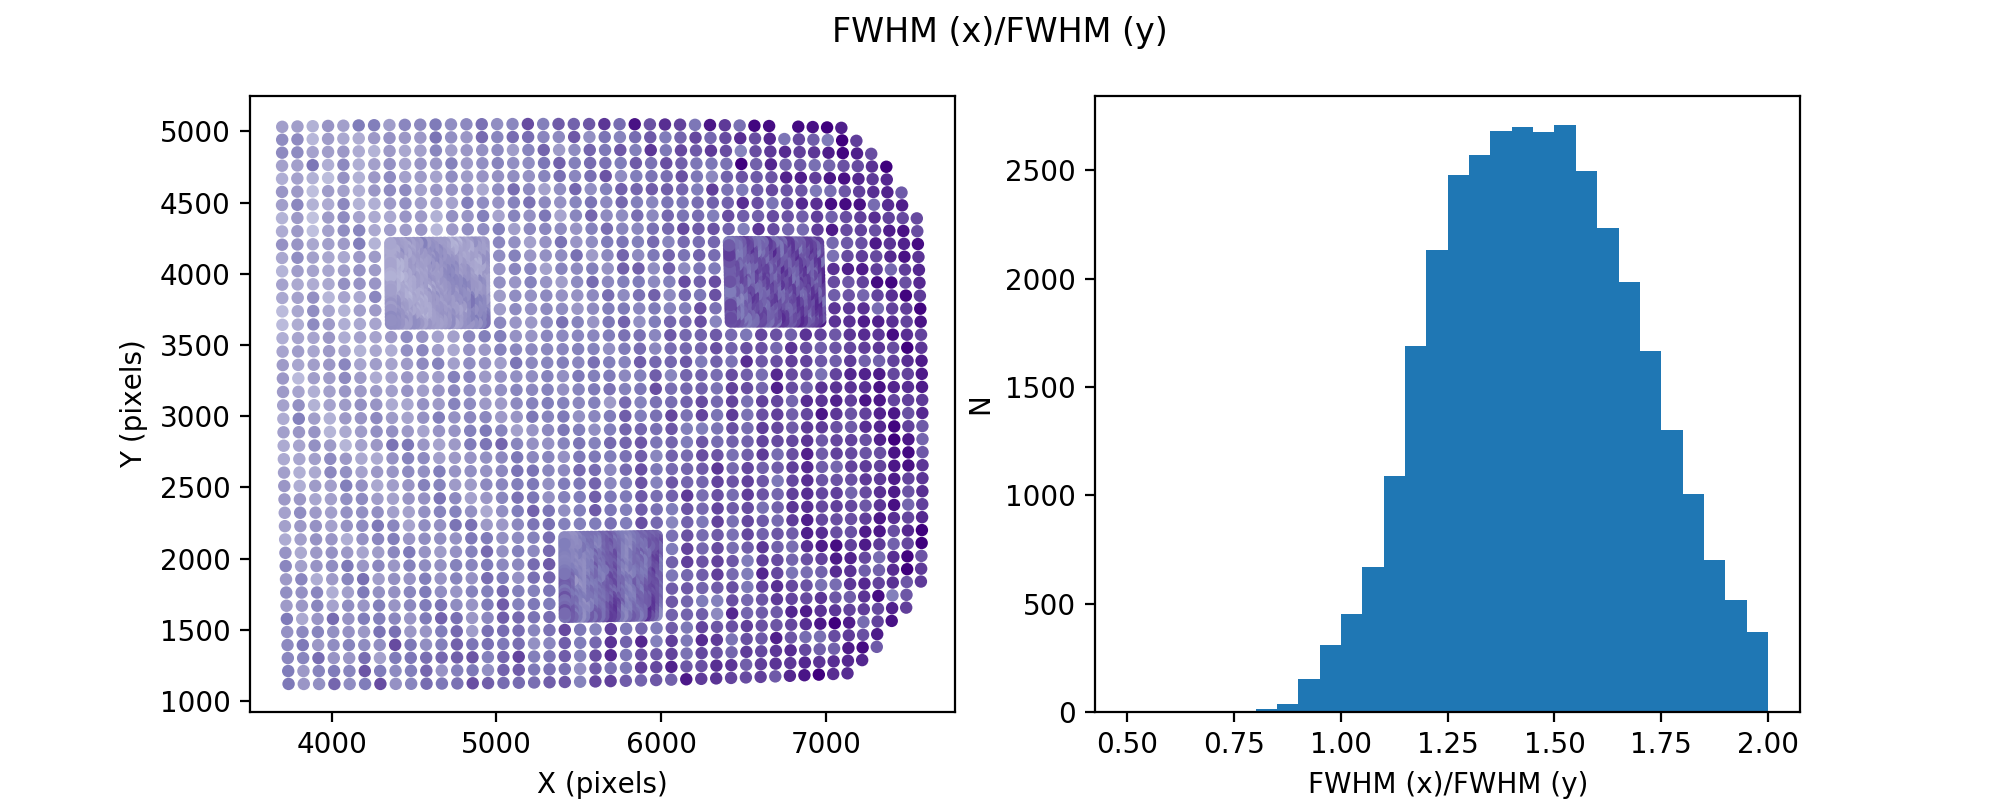

In [33]:
reload(visplot)

plotRange=None
nbins=30

plotRange=[0,0.1]
visplot.pairPlot(xfirst,yfirst,rmsVal,rmsVal.ravel(),plotRange,"RMS",prefix,"_rms","RMS","pixels",nbins,inter,stitle=stitle)
plotRange=[3,7]
visplot.pairPlot(xfirst,yfirst,fxAv,fxArray.ravel(),plotRange,"FWHM (x)",prefix,"_fwhmx","FWHM (x)","pixels",nbins,inter,stitle=stitle)
plotRange=[2,8]
visplot.pairPlot(xfirst,yfirst,fyAv,fyArray.ravel(),plotRange,"FWHM (y)",prefix,"_fwhmy","FWHM (y)","pixels",nbins,inter,stitle=stitle)
plotRange=[0.5,2]
visplot.pairPlot(xfirst,yfirst,fxAv/fyAv,(fxArray/fyArray).ravel(),plotRange,"FWHM (x)/FWHM (y)",prefix,"_fwhmxy","FWHM (x)/FWHM (y)","pixels",nbins,inter,stitle=stitle)



<IPython.core.display.Javascript object>


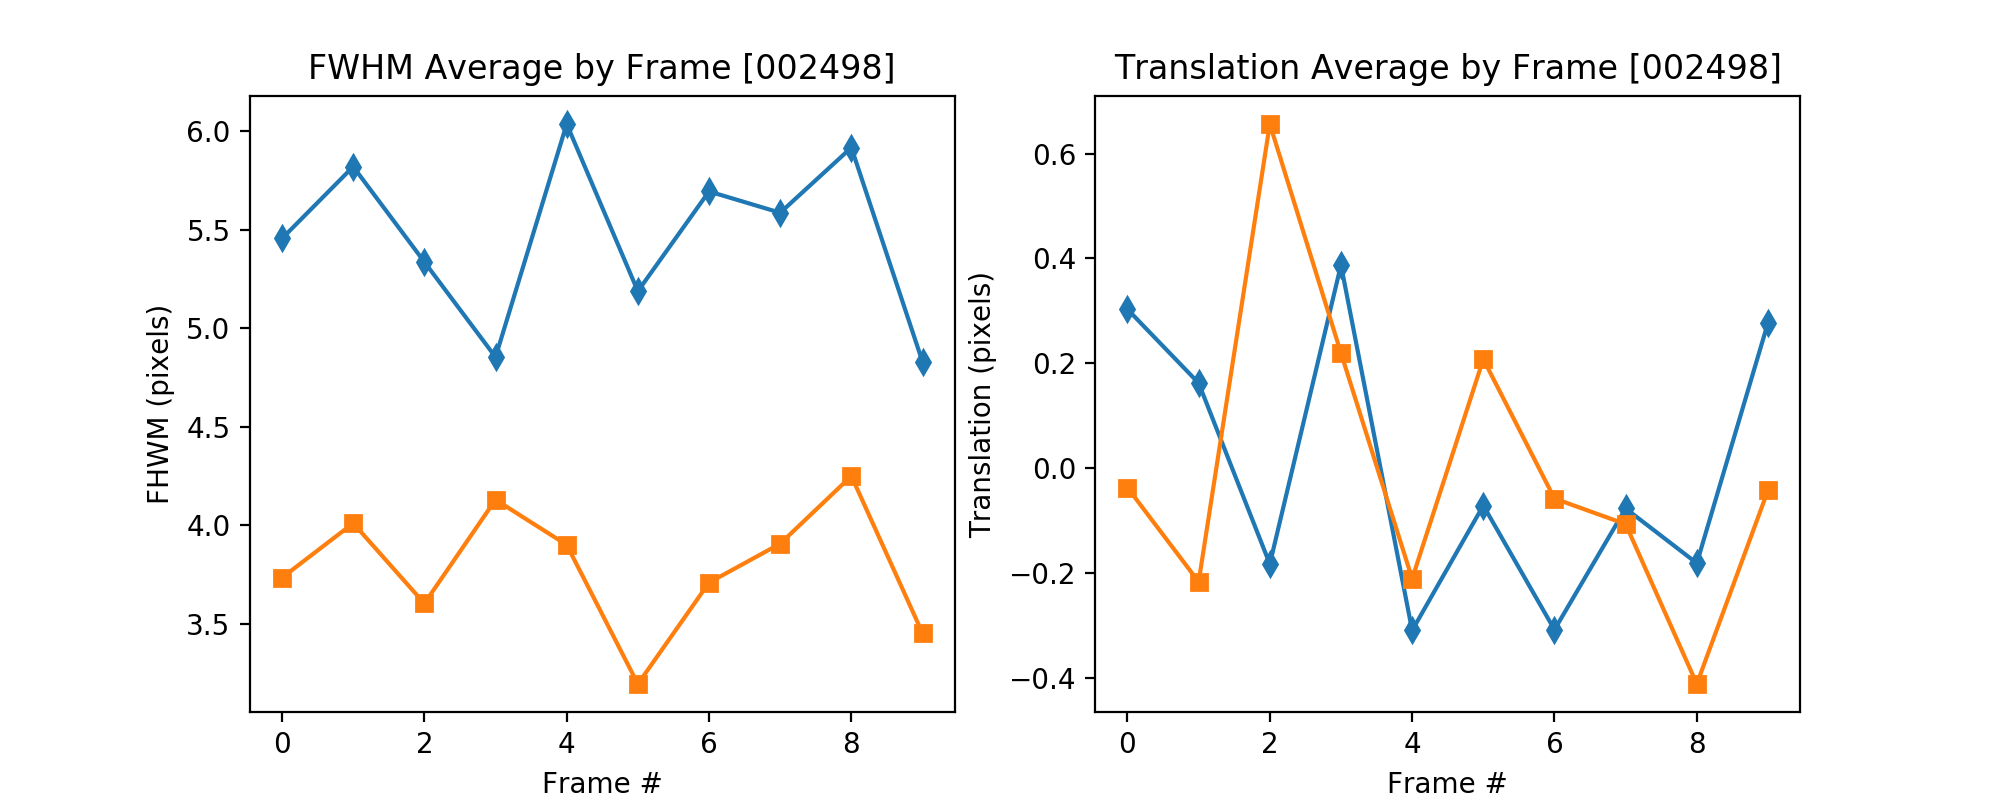

<IPython.core.display.Javascript object>


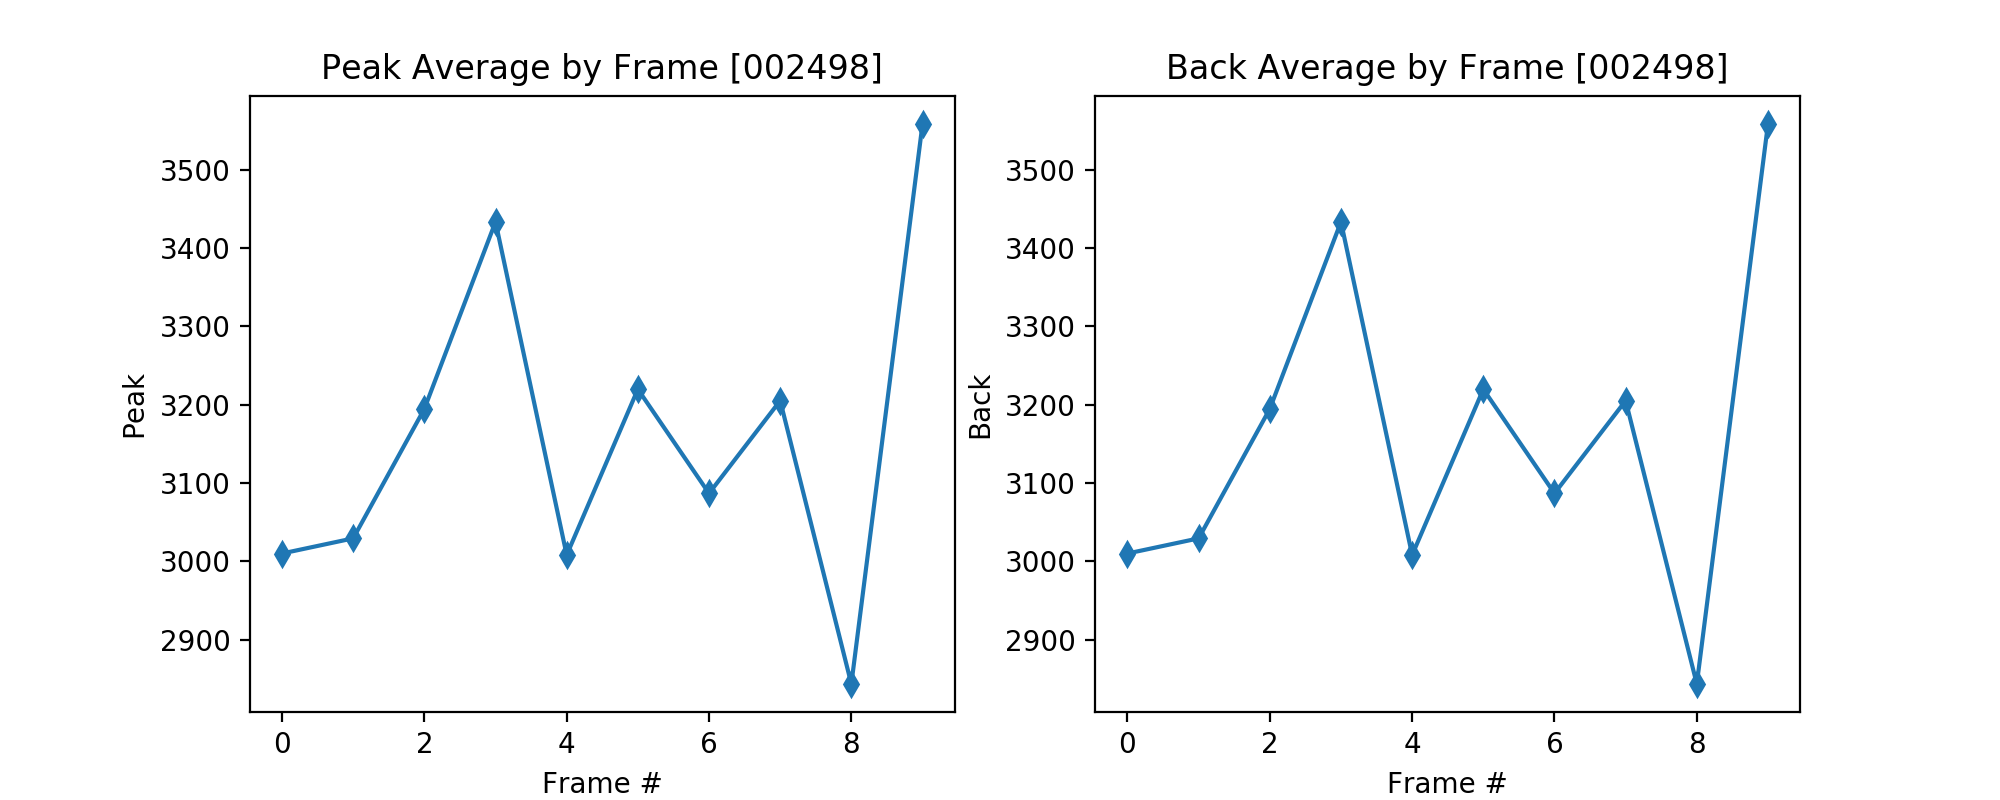

<IPython.core.display.Javascript object>


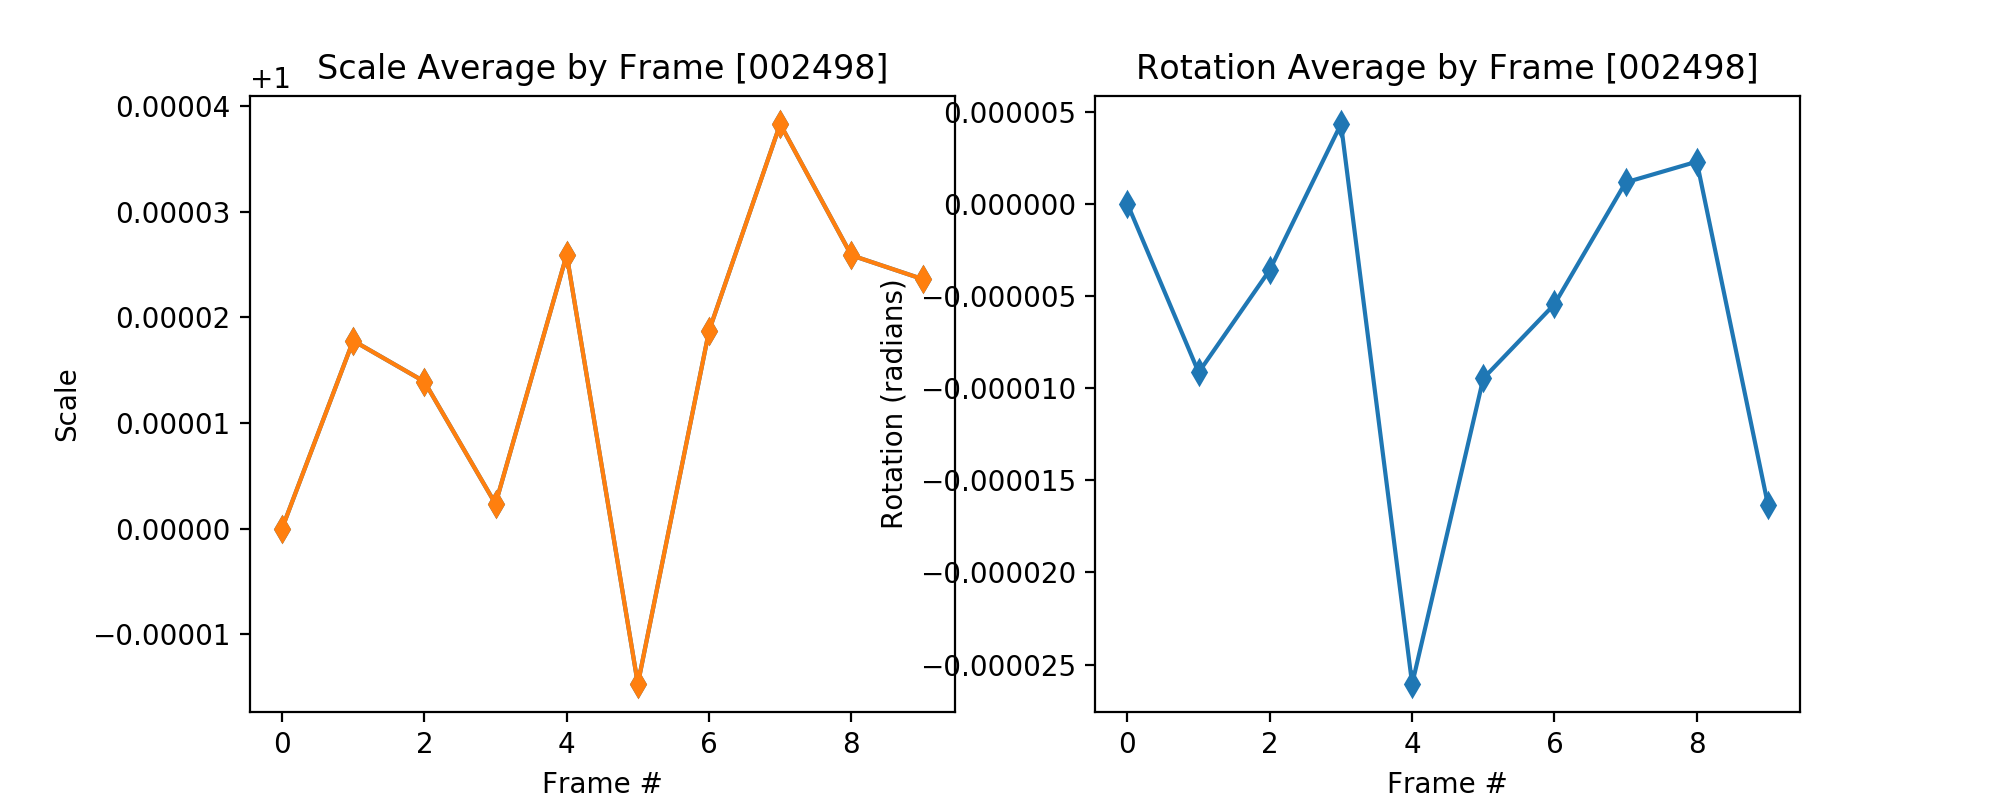

In [30]:

reload(visplot)
visplot.plotTransByFrame(fxFrameAv,fyFrameAv,peakFrameAv,sxAll,syAll,xdAll,ydAll,rotAll,prefix,inter,stitle=stitle)


# Data IO

This writes the calculated variables to a yaml file for later use. The file name is set by the frame ID and an incremental integer (so that old versions are not overwritten). 

The routine creates a dictionary which is dumpted to file, and can be read back in. 
